In [2]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

In [3]:
# 读取数据（确保正确处理空格）
df = pd.read_csv('D:\\2024test.csv', skipinitialspace=True)  # 跳过初始空格

# 检查 radiation 列
print("是否存在 NaN:", df["radiation"].isna().any())
print("是否存在 Inf:", np.isinf(df["radiation"]).any())
print("唯一值示例:", df["radiation"].unique()[:10])  # 查看前10个唯一值
print("最大值:", df["radiation"].max())
print("最小值:", df["radiation"].min())
# 移除空格并转换为 float
df["radiation"] = df["radiation"].astype(str).str.strip().replace("", np.nan).astype(float)

是否存在 NaN: False
是否存在 Inf: False
唯一值示例: [  0.    23.68 357.38 582.58 706.73 763.16 766.68 717.16 591.71 371.44]
最大值: 993.52
最小值: 0.0


In [4]:
# 读取数据（确保正确处理空格）
df = pd.read_csv('D:\\2025test.csv', skipinitialspace=True)  # 跳过初始空格

# 检查 radiation 列
print("是否存在 NaN:", df["radiation"].isna().any())
print("是否存在 Inf:", np.isinf(df["radiation"]).any())
print("唯一值示例:", df["radiation"].unique()[:10])  # 查看前10个唯一值
print("最大值:", df["radiation"].max())
print("最小值:", df["radiation"].min())
# 移除空格并转换为 float
df["radiation"] = df["radiation"].astype(str).str.strip().replace("", np.nan).astype(float)

是否存在 NaN: False
是否存在 Inf: False
唯一值示例: [  0.    22.45 546.64 667.86 714.28 704.38 667.82 524.63 266.39   0.75]
最大值: 1077.88
最小值: 0.0


In [5]:
import pandas as pd
import optuna
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 加载训练集和验证集数据（2024年数据）
train_val_data = pd.read_csv('D:\\2024test.csv')
X_train_val = train_val_data.drop(columns=['O3','date'])
y_train_val = train_val_data['O3']

# 加载独立的测试集数据（2025年数据）
test_data = pd.read_csv('D:\\2025test.csv')
X_test = test_data.drop(columns=['O3','date'])
y_test = test_data['O3']

# 从训练+验证集中划分训练集和验证集（90%训练，10%验证）
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.1,  # 10%作为验证集
    random_state=42
)

# 检查划分比例
print("="*50)
print("数据集划分比例：")
print(f"训练集 (2024年部分): {len(X_train) / len(X_train_val):.1%}")
print(f"验证集 (2024年部分): {len(X_val) / len(X_train_val):.1%}")
print(f"测试集 (2025年完整数据): {len(X_test)}条记录")
print("="*50)

数据集划分比例：
训练集 (2024年部分): 90.0%
验证集 (2024年部分): 10.0%
测试集 (2025年完整数据): 10329条记录


In [6]:
def objective(trial):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        'verbose': -1,
        'random_state': 42,
    }

    # 创建LightGBM模型
    model = lgb.LGBMRegressor(**params)
    
    # 使用验证集进行早停
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(stopping_rounds=10, verbose=False),
            lgb.log_evaluation(period=0)  # 不输出训练日志
        ]
    )
    
    # 预测验证集并计算RMSE
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    # 记录最佳迭代次数（用于最终训练）
    trial.set_user_attr('best_iteration', model.best_iteration_)
    
    return rmse

# 创建优化研究
print("开始参数优化...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# 获取并显示最佳参数
best_params = study.best_params
best_iteration = study.best_trial.user_attrs['best_iteration']

# 添加固定参数
best_params.update({
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42,
    'verbose': -1,
    'n_estimators': best_iteration  # 使用最佳迭代次数
})

print("\n" + "="*50)
print(f"{'最佳参数':^50s}")
print("="*50)
for key, value in best_params.items():
    print(f"{key:>20s}: {value}")
print("="*50 + "\n")

# 使用最佳参数训练最终模型（使用全部2024年数据）
print("训练最终模型...")
light_model = lgb.LGBMRegressor(**best_params)

# 训练模型（使用全部2024年数据）
light_model.fit(
    X_train_val,  # 使用全部2024年数据
    y_train_val,
    callbacks=[lgb.log_evaluation(period=0)]  # 不输出训练日志
)

# 在独立测试集（2025年数据）上预测
y_pred = light_model.predict(X_test)

# 计算评估指标
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("="*50)

[I 2025-07-10 16:53:26,549] A new study created in memory with name: no-name-b20f963c-2a3d-4052-ac8f-998c0605163e


开始参数优化...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-10 16:53:28,307] Trial 0 finished with value: 21.810766496963527 and parameters: {'num_leaves': 144, 'min_child_samples': 17, 'feature_fraction': 0.42390179043338005, 'bagging_fraction': 0.22247968896950826, 'bagging_freq': 2, 'learning_rate': 0.0036655132361694885, 'n_estimators': 344, 'min_split_gain': 0.8675895362059691, 'lambda_l1': 0.9637064206487712, 'lambda_l2': 0.9303633978000712}. Best is trial 0 with value: 21.810766496963527.
[I 2025-07-10 16:53:33,535] Trial 1 finished with value: 10.034746934988524 and parameters: {'num_leaves': 245, 'min_child_samples': 52, 'feature_fraction': 0.9853053451144814, 'bagging_fraction': 0.5937944386289062, 'bagging_freq': 5, 'learning_rate': 0.028320776194490586, 'n_estimators': 788, 'min_split_gain': 0.04895297468750226, 'lambda_l1': 0.11033203500944055, 'lambda_l2': 0.8364570693663991}. Best is trial 1 with value: 10.034746934988524.
[I 2025-07-10 16:53:35,490] Trial 2 finished with value: 10.644933447282986 and parameters: {'num

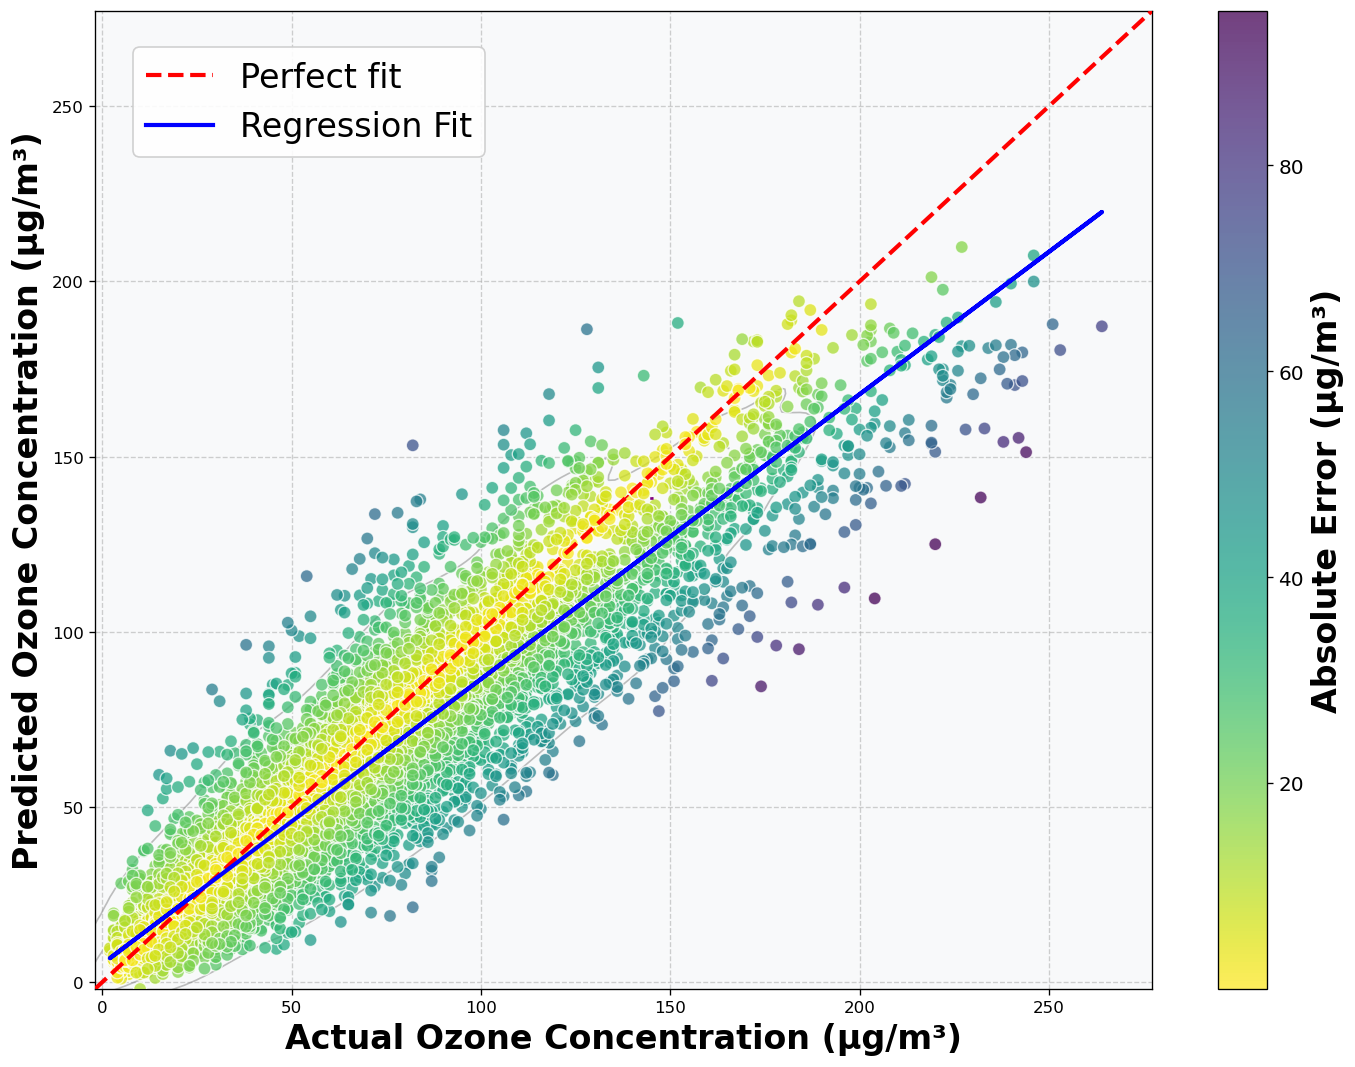

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
from matplotlib.patches import Arc

# 设置全局绘图参数
plt.figure(figsize=(12, 9), dpi=120)
plt.rcParams['font.family'] = 'DejaVu Sans'  # 使用支持中文的字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 1. 创建散点图（专业风格）
scatter = plt.scatter(y_test, y_pred, 
                    c=np.abs(y_test - y_pred),  # 颜色表示误差大小
                    cmap='viridis_r',  # 反转色图，使高误差更明显
                    alpha=0.75, 
                    s=60, 
                    edgecolor='w', 
                    linewidth=0.8,
                    zorder=3)  # 设置图层顺序

# 2. 添加完美拟合线（红色虚线）
min_val = min(y_test.min(), y_pred.min()) * 0.95
max_val = max(y_test.max(), y_pred.max()) * 1.05
perfect_fit, = plt.plot([min_val, max_val], [min_val, max_val], 
                      'r--', linewidth=2.5, label='Perfect fit', zorder=5)  # 较高图层顺序

# 3. 添加回归拟合线（蓝色实线）
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
reg_line = slope * y_test + intercept
reg_fit, = plt.plot(y_test, reg_line, 
                  'b-', linewidth=2.5, 
                  label='Regression Fit', zorder=5)  # 较高图层顺序

# 计算两条线之间的夹角
m1 = 1.0  # 完美拟合线斜率 (y = x)
m2 = slope  # 回归线斜率

# 避免除零错误
if abs(1 + m1 * m2) > 1e-6:
    angle_rad = abs(math.atan((m2 - m1) / (1 + m1 * m2)))
    angle_deg = abs(math.degrees(angle_rad))
else:
    angle_deg = 90.0  # 线垂直

# 4. 计算并显示评估指标
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# # 创建评估指标文本
# metrics_text = (
#     f'$R^2$ = {r2:.3f}\n'
#   f'RMSE = {rmse:.2f} μg/m³\n'
#     f'MAE = {mae:.2f} μg/m³\n'
#    f'sample = {len(y_test)}\n'
#     f'angle = {angle_deg:.1f}°'
# )

# # 添加半透明文本框
# plt.text(0.05, 0.95, metrics_text, 
#         transform=plt.gca().transAxes, fontsize=14,
#         verticalalignment='top',
#         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 6. 设置主图标签和标题
plt.xlabel('Actual Ozone Concentration (μg/m³)', fontsize=20, fontweight='bold')
plt.ylabel('Predicted Ozone Concentration (μg/m³)', fontsize=20, fontweight='bold')
#plt.title('LightGBM Optimized Model Performance', fontsize=16, pad=15)  # 修改标题

# 7. 添加图例（位置优化）
#plt.legend(loc='lower right', fontsize=12, frameon=True, framealpha=0.9)
plt.legend(loc='upper left',bbox_to_anchor=(0.02, 0.98), fontsize=20, frameon=True, framealpha=0.9)
# 8. 添加颜色条
cbar = plt.colorbar(scatter)
cbar.set_label('Absolute Error (μg/m³)', fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=12)  # 设置颜色条刻度字体大小


# 10. 设置坐标轴范围
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# 11. 添加数据点密度等高线（当数据密集时）
if len(y_test) > 100:
    sns.kdeplot(x=y_test, y=y_pred, 
                levels=5, color='gray', alpha=0.5, linewidths=1,
                thresh=0.05, zorder=2)  # 较低图层顺序

# 12. 设置网格和背景
plt.grid(True, linestyle='--', alpha=0.6, zorder=1)
plt.gca().set_facecolor('#f8f9fa')

# 13. 添加Optuna优化信息
#plt.annotate(f"Optuna Optimize n_trials=({len(study.trials)})", 
#            xy=(0.02, 0.02), xycoords='axes fraction',
#            fontsize=9, ha='left', va='bottom', 
#            color='gray', alpha=0.7)

# 添加角度可视化（在代表性点）
mid_x = (min_val + max_val) / 2
plt.plot([mid_x - 5, mid_x + 5], [mid_x - 5, mid_x + 5], 'r--', linewidth=1, zorder=4)  # 完美拟合线段
plt.plot([mid_x - 5, mid_x + 5], 
         [slope*(mid_x - 5) + intercept, slope*(mid_x + 5) + intercept], 
         'b-', linewidth=1, zorder=4)  # 回归拟合线段

# 添加角度弧线
ax = plt.gca()
arc = Arc((mid_x, mid_x), 15, 15, theta1=0, theta2=angle_deg, 
          edgecolor='purple', linewidth=2, zorder=6)
ax.add_patch(arc)

# #添加角度标签
# plt.text(mid_x + 8, mid_x + 2, f'{angle_deg:.1f}°', 
#         fontsize=12, color='purple', ha='center', va='center',
#         bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('lightgbm_ozone_prediction_fit.png', dpi=300, bbox_inches='tight')
plt.show()